In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from scipy.constants import h,k,c
from scipy.optimize import curve_fit, brute
from astropy import units as u
from astropy.modeling.blackbody import blackbody_lambda, blackbody_nu
import time

import astropy
print astropy.__version__

import scipy
print scipy.__version__

import matplotlib
print matplotlib.__version__

print "Dependencies imported"

2.0.2
0.19.1
2.1.0
Dependencies imported


In [3]:
filternamevec = ['g','r','i','z','y','J','H','K','W1','W2','W3','W4']
filterzps = [3631., 3631., 3631., 3631., 3631., 1594., 1024., 666.7, 309.54, 171.787, 31.674, 8.363]
filtercentwav = [0.4810, 0.6170, 0.7520, 0.8660, 0.9620, 1.235, 1.662, 2.159, 3.35, 4.60, 11.56, 22.08]

class FullSubject:
    def __init__(self, vec):
        self.zooniverse_id = vec[8]
        self.wiseid = vec[7]
        self.ra = float(vec[1])
        self.dec = float(vec[2])
        self.glong = float(vec[9])
        self.glat = float(vec[10])

        self.jmag = float(vec[19])
        self.jmagerr = float(vec[20])
        self.hmag = float(vec[21])
        self.hmagerr = float(vec[22])
        self.kmag = float(vec[23])
        self.kmagerr = float(vec[24])
        tempw1mag = float(vec[11])
        tempw1magerr = float(vec[12])
        tempw2mag = float(vec[13])
        tempw2magerr = float(vec[14])
        self.w3mag = float(vec[15])
        self.w3magerr = float(vec[16])
        self.w4mag = float(vec[17])
        self.w4magerr = float(vec[18])
        
        if tempw1mag > 8.:
            self.w1mag = tempw1mag + 0.
            self.w1magerr = tempw1magerr + 0.
        else:
            self.w1mag = tempw1mag + (0. - 0.1359 + (0.0396*tempw1mag) - (0.0023*tempw1mag*tempw1mag)) - 0.031
            self.w1magerr = (((1. + 0.0396 - (0.0046*tempw1mag))**2) * (tempw1magerr**2))**0.5
            
        if tempw2mag > 6.7:
            self.w2mag = tempw2mag + 0.
            self.w2magerr = tempw2magerr + 0.
        elif tempw2mag > 5.4:
            self.w2mag = tempw2mag + (-0.3530 + (0.8826*tempw2mag) - (0.2380*(tempw2mag**2)) + (0.0170*(tempw2mag**3))) + 0.004
            self.w2magerr = (((1. + 0.8826 - (0.4760 * tempw2mag) + (0.0510 * (tempw2mag**2)))**2) * (tempw2magerr**2))**0.5
        else:
            self.w2mag = tempw2mag + (1.5777 - (0.3495*tempw2mag) + (0.0160*(tempw2mag**2))) + 0.004
            self.w2magerr = (((1. - 0.3495 + (2.*0.0160*tempw2mag))**2) * (tempw2magerr**2))**0.5

        self.psgmag = float(vec[53])
        self.psgmagerr = float(vec[54])
        self.psimag = float(vec[55])
        self.psimagerr = float(vec[56])
        self.psrmag = float(vec[57])
        self.psrmagerr = float(vec[58])
        self.psymag = float(vec[59])
        self.psymagerr = float(vec[60])
        self.pszmag = float(vec[61])
        self.pszmagerr = float(vec[62])
        
        self.has_ps_gminr = (not math.isnan(self.psgmag)) and (not math.isnan(self.psrmag))
        if self.has_ps_gminr:
            self.psgminr = self.psgmag - self.psrmag
            self.psgminrerr = ((self.psgmagerr**2) + (self.psrmagerr**2))**0.5
        else:
            self.psgminr = float('NaN')
        
        self.sourcevec = vec
        
        filtinputvec = [self.psgmag, self.psrmag, self.psimag, self.pszmag, self.psymag, self.jmag, self.hmag, self.kmag, self.w1mag, self.w2mag, self.w3mag, self.w4mag]
        filterrinputvec = [self.psgmagerr, self.psrmagerr, self.psimagerr, self.pszmagerr, self.psymagerr, self.jmagerr, self.hmagerr, self.kmagerr, self.w1magerr, self.w2magerr, self.w3magerr, self.w4magerr]
        
        self.filts_temp = []
        self.mags_temp = []
        self.magerrs_temp = []
        self.fluxes_temp = []
        self.fluxerrs_temp = []
        self.centwavs_temp = []
        
        for i in range(len(filtinputvec)):
            if math.isnan(filtinputvec[i]):
                continue
            else:
                self.filts_temp.append(filternamevec[i])
                self.mags_temp.append(filtinputvec[i])
                self.magerrs_temp.append(filterrinputvec[i])
                self.fluxes_temp.append(filterzps[i] * (10.**(-0.4*filtinputvec[i])))
                self.fluxerrs_temp.append(0.4*np.log(10.)*filterrinputvec[i]*(filterzps[i] * (10.**(-0.4*filtinputvec[i]))))
                self.centwavs_temp.append(filtercentwav[i])
                
        self.filts_long = np.array(self.filts_temp)
        self.mags_long = np.array(self.mags_temp)
        self.magerrs_long = np.array(self.magerrs_temp)
        self.fluxes_long = np.array(self.fluxes_temp) * 1.e-23
        self.fluxerrs_long = np.array(self.fluxerrs_temp) * 1.e-23
        self.centwavs_microns_long = np.array(self.centwavs_temp)
        self.centwavs_meters_long = self.centwavs_microns_long * 1.e-6
        self.centwavs_Hz_long = c/self.centwavs_meters_long
        self.nuFnu_long = self.centwavs_Hz_long * self.fluxes_long
        self.nuFnuerrs_long = self.centwavs_Hz_long * self.fluxerrs_long
        
        self.centwavs_microns = self.centwavs_microns_long[-7:]
        self.centwavs_meters = self.centwavs_microns * 1.e-6
        self.centwavs_Hz = c/self.centwavs_meters
        self.nuFnu = self.nuFnu_long[-7:]
        self.nuFnuerrs = self.nuFnuerrs_long[-7:]
                
        self.Teff = None
        self.Teff_err = None
        self.rdstar = None
        self.rdstar_err = None
        self.Tdisk = None
        self.Tdisk_err = None
        self.xdisk = None
        self.xdisk_err = None
        self.fir = None
        
        self.nuFnu_star = None
        self.nuFnu_disk = None

    def __str__(self):
        s = ''
        for entry in self.sourcevec:
            s = s + str(entry) + ','

        s = s[:-1]

        return s
    
print "Class read in"

Class read in


In [4]:
def get_data(filename):
    df = pd.read_csv(filename, low_memory = False)
    
    data = df.values
    
    return data

Subjects read in
AWI0002d6a
J033549.39+641324.7
-12.5 -8.0


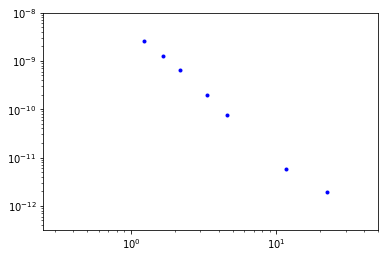

AWI0005yjn
J022317.32+381509.7
-12.0 -7.5


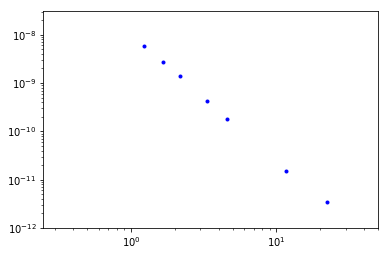

In [5]:
inputdata = get_data('sed_input_data.csv')

#print inputdata[1,:]

columnlabels = inputdata[1,:]

columncount = columnlabels.size

columnlabel_index_dict = {}

for i in range(columncount):
    columnlabel_index_dict[columnlabels[i]] = i

    
#from pprint import pprint
#pprint(columnlabel_index_dict)
    
inputdata_use = inputdata[5:,:]

#print inputdata_use.shape

num_subjs = inputdata_use[:,0].size

raw_subjs = []

for i in range(num_subjs):
    raw_subjs.append(FullSubject(inputdata_use[i,:]))
    
print "Subjects read in"

#print columnlabels
#print raw_subjs[180].sourcevec

#print raw_subjs[180].sourcevec[columnlabel_index_dict[' P_gMeanPSFMag']]

#print raw_subjs[180].filts
#print raw_subjs[180].mags
#print raw_subjs[180].magerrs
#print raw_subjs[180].fluxes
#print raw_subjs[180].fluxerrs
#print raw_subjs[180].centwavs_microns
print raw_subjs[40].zooniverse_id
print raw_subjs[40].wiseid

plt.errorbar(raw_subjs[40].centwavs_microns, raw_subjs[40].nuFnu, yerr=raw_subjs[40].nuFnuerrs, fmt='b.')
min_nuFnu_logs = min(np.log10(raw_subjs[40].nuFnu))
max_nuFnu_logs = max(np.log10(raw_subjs[40].nuFnu))

ymin = float(np.floor((min_nuFnu_logs-0.5)*2.))/2.
ymax = float(np.ceil(2.*(max_nuFnu_logs+0.5)))/2.

print ymin, ymax

plt.xscale("log", nonposx='clip')
plt.yscale("log", nonposy='clip')
plt.xlim([0.25, 50.])
plt.ylim([10.**ymin, 10.**ymax])
plt.show()

print raw_subjs[20].zooniverse_id
print raw_subjs[20].wiseid

plt.errorbar(raw_subjs[20].centwavs_microns, raw_subjs[20].nuFnu, yerr=raw_subjs[20].nuFnuerrs, fmt='b.')
min_nuFnu_logs = min(np.log10(raw_subjs[20].nuFnu))
max_nuFnu_logs = max(np.log10(raw_subjs[20].nuFnu))

ymin = float(np.floor((min_nuFnu_logs-0.5)*2.))/2.
ymax = float(np.ceil(2.*(max_nuFnu_logs+0.5)))/2.

print ymin, ymax

plt.xscale("log", nonposx='clip')
plt.yscale("log", nonposy='clip')
plt.xlim([0.25, 50.])
plt.ylim([10.**ymin, 10.**ymax])
plt.show()

In [6]:
def star_fitter(centwavs, Teff, rdstar):
    centwavs_angstroms = centwavs * 1.e10 * u.AA
    centwavs_meters = centwavs * u.m
    
    #print centwavs_angstroms
    #print Teff
    
    #print blackbody_lambda(centwavs_angstroms[0], Teff*u.K)
    
    #flux_lam_temp = []
    #for wav in centwavs_angstroms:
    #    flux_lam_temp.append(blackbody_lambda(wav, Teff*u.K) * np.pi * u.sr)
    
    flux_lam_temp = blackbody_lambda(centwavs_angstroms, Teff*u.K) * np.pi * u.sr 
    
    #print flux_lam_temp
    
    flux_lam = flux_lam_temp * centwavs_angstroms * u.cm * u.cm * u.s / u.erg
    
    #print flux_lam 
    
    return flux_lam * rdstar
    

def get_star_fit(subj):
    nuFnu_use = subj.nuFnu[:-3]
    nuFnu_err_use = subj.nuFnuerrs[:-3]
    cent_wavs_use = subj.centwavs_meters[:-3]
    
    #print nuFnu_use
    #print nuFnu_err_use
    
    Teff_guess = 5000.
    rdstar_guess = 1.e-10
    
    #print nuFnu_use
    
    popt, pcov = curve_fit(star_fitter, cent_wavs_use, nuFnu_use, sigma = nuFnu_err_use, bounds = (0, [50000., 1.e-14]))
    
    Teff_opt = popt[0]
    rdstar_opt = popt[1]
    
    subj.Teff = popt[0]
    subj.Teff_err = (pcov[0,0])**2
    subj.rdstar = popt[1]
    subj.rdstar_err = (pcov[1,1])**2
    
    subj.nuFnu_star = blackbody_lambda(subj.centwavs_meters * 1.e10 * u.AA, subj.Teff * u.K) * np.pi * u.sr * (subj.centwavs_meters * 1.e10 * u.AA) * subj.rdstar * u.cm * u.cm * u.s / u.erg
    
    
    subj.nuFnu_disk = subj.nuFnu - subj.nuFnu_star
    
    subj.nuFnu_disk_errs = subj.nuFnuerrs
    
    return subj

start_time = time.time()
subjs_with_star_fits = []

print start_time

for subj in raw_subjs:
    subjs_with_star_fits.append(get_star_fit(subj))
    
star_fit_end_time = time.time()
    
print "Star fits done"
print "Time elapsed:", star_fit_end_time - start_time

1516200986.1
Star fits done
Time elapsed: 300.908000231


AWI0002d6a
J033549.39+641324.7
10232.154808 1.85836756447e-180
3.4206364278e-20
154.863841558 10301176683.5
[-0.01389846 -2.31860879  2.89052409  8.16834161]
[ 8.16834161]
1
(85.0, 1.436586384642253e-15)
61
10232.154808 1.85836756447e-180
154.863841558 10301176683.5
7.05377377693e-05


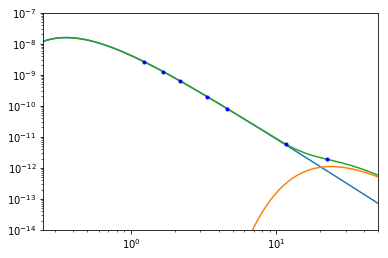

In [84]:
def disk_fitter(centwavs, Tdisk, xdisk):
    centwavs_angstroms = centwavs * 1.e10 * u.AA
    centwavs_meters = centwavs * u.m
    
    #print centwavs_angstroms
    #print Teff
    
    #print blackbody_lambda(centwavs_angstroms[0], Teff*u.K)
    
    #flux_lam_temp = []
    #for wav in centwavs_angstroms:
    #    flux_lam_temp.append(blackbody_lambda(wav, Teff*u.K) * np.pi * u.sr)
    
    flux_lam_temp = blackbody_lambda(centwavs_angstroms, Tdisk*u.K) * np.pi * u.sr 
    
    #print flux_lam_temp
    
    flux_lam = flux_lam_temp * centwavs_angstroms * u.cm * u.cm * u.s / u.erg
    
    #print flux_lam 
    
    return flux_lam * xdisk
    
def get_objective_function_value(subj, Tdiskguess, xdiskguess):
    #Tdiskguess, xdiskguess = params
    flux_lam_fit_disk = disk_fitter(subj.centwavs_meters, Tdiskguess, xdiskguess)
    
    flux_lam_fit = flux_lam_fit_disk + subj.nuFnu_star
    
    flux_lam = subj.nuFnu
    flux_lam_errs = subj.nuFnuerrs
    
    #print min(flux_lam_errs)
    
    chiconts = np.zeros(flux_lam.size)
    
    for i in range(flux_lam.size):
        chiconts[i] = ((flux_lam[i] - flux_lam_fit[i])/flux_lam_errs[i])**2
        
    chisum = np.sum(chiconts)
    
    return chisum
        

def get_disk_fit(subj):
    nuFnu_use = subj.nuFnu_disk[-4:]
    nuFnu_err_use = subj.nuFnu_disk_errs[-4:]
    cent_wavs_use = subj.centwavs_meters[-4:]
    
    #print nuFnu_use
    #print nuFnu_err_use
    #print cent_wavs_use
    
    Tstar = subj.Teff
    rdstar = subj.rdstar
    
    sig_nuFnu_use = nuFnu_use / nuFnu_err_use
    print sig_nuFnu_use
    print sig_nuFnu_use[sig_nuFnu_use > 5.]
    print sig_nuFnu_use[sig_nuFnu_use > 5.].size
    
    if sig_nuFnu_use[sig_nuFnu_use > 5.].size < 1:
        print "No significant excess"
        return subj
    elif sig_nuFnu_use[sig_nuFnu_use > 5.].size > 1:
        popt, pcov = curve_fit(disk_fitter, cent_wavs_use, nuFnu_use, guess, sigma = nuFnu_err_use)
        
        subj.Tdisk = popt[0]
        subj.xdisk = popt[1]
        
        return subj
    
    else:
    #lambda_max_star = (2.8977729e-3 / Tstar)
    
    #peak_flux_star = blackbody_lambda((lambda_max_star*1.e10*u.AA), (Tstar*u.K))
    
    #lambda_max_disk = (2.8977729e-3 / 1.)
    
    #test_min_peak_flux_disk = blackbody_lambda((lambda_max_disk*1.e10*u.AA), (1.*u.K))
    #test_max_peak_flux_disk = blackbody_lambda(((2.8977729e-3/500.)*1.e10*u.AA), (500.*u.K))
    
    #test_min_peak_flux_disk_at_star = blackbody_lambda((lambda_max_star*1.e10*u.AA), (1.*u.K))
    #test_max_peak_flux_disk_at_star = blackbody_lambda(((lambda_max_star*1.e10*u.AA), (500.*u.K)))
    
    #test_min_peak_flux_star_at_disk = blackbody_lambda((lambda_max_disk*1.e10*u.AA), (Tstar*u.K))
    #test_max_peak_flux_star_at_disk = blackbody_lambda(((2.8977729e-3/500.)*1.e10*u.AA), (Tstar*u.K))
    
    
    
    
    #xdiskmax = 0.1 * rdstar * ((lambda_max_star * peak_flux_star) - (lambda_max_disk * test_min_peak_flux_star_at_disk))/((lambda_max_disk * test_min_peak_flux_disk) - (lambda_max_star * test_min_peak_flux_disk_at_star))
    #xdiskmin = 0.1* float((peak_flux_star / test_max_peak_flux_disk)) * (lambda_max_star/(2.8977729e-3/500.)) * rdstar
    
    #Tdiskmax = 0.1*Tstar
    #xdiskmax = 2.e14*rdstar
    #xdiskmin = float(1.e9*rdstar)
    
    #print xdiskmin, xdiskmax
    
        Tdiskvals = np.linspace(5., 300., 60)
    #xdiskvals = np.linspace(xdiskmin, 1.e11*rdstar, 51)
    
    #valgrid = np.zeros(51*51).reshape(51,51)
    #reschi = np.zeros(51*51).reshape(51,51)
    
        val_chi_dict = {}
    
        for i in range(60):
            Tdiskval = Tdiskvals[i]
        
            xdiskmax = subj.rdstar * 1.e-2 * ((subj.Teff/Tdiskval)**4)
            xdiskmin = subj.rdstar * 1.e-9 * ((subj.Teff/Tdiskval)**4)
         
            xdiskvals = np.linspace(xdiskmin, xdiskmax, 51)
            for j in range(51):
                val_chi_dict[(Tdiskvals[i], xdiskvals[j])] = get_objective_function_value(subj, Tdiskvals[i], xdiskvals[j])
                #valgrid[i,j] = (Tdiskvals[i], xdiskvals[j])
                #reschi[i,j] = get_objective_function_value(subj, Tdiskvals[i], xdiskvals[j])
    
        minchi = np.inf
        minchi_vals = None
    
        possible_minchi_vals = []
    
        for key in val_chi_dict.keys():
            if val_chi_dict[key] < minchi:
                minchi = val_chi_dict[key]
                minchi_vals = key

        for key in val_chi_dict.keys():
            if (val_chi_dict[key] - minchi)/(minchi) < 1.:
                possible_minchi_vals.append(key)
                
    #from pprint import pprint
    #pprint(val_chi_dict)
                
        print minchi_vals
        print len(possible_minchi_vals)
    
        possible_minchi_results_dict = {}
        possible_minchi_chi_dict = {}
    
        for possible_minchi_val in possible_minchi_vals:
            guess = np.array([possible_minchi_val[0], possible_minchi_val[1]])
    
        #print nuFnu_use
    
            popt, pcov = curve_fit(disk_fitter, cent_wavs_use, nuFnu_use, guess, sigma = nuFnu_err_use)
    
            possible_minchi_results_dict[possible_minchi_val] = np.array(popt)
            possible_minchi_chi_dict[possible_minchi_val] = get_objective_function_value(subj, popt[0], popt[1])
    
        final_minchi = np.inf
        final_minchi_vals = None
    
        for key in possible_minchi_chi_dict.keys():
            if possible_minchi_chi_dict[key] < final_minchi:
                final_minchi = possible_minchi_chi_dict[key]
                final_minchi_vals = possible_minchi_results_dict[key]
    
        subj.Tdisk = final_minchi_vals[0]
        #subj.Tdisk_err = (pcov[0,0])**2
        subj.xdisk = final_minchi_vals[1]
        #subj.xdisk_err = (pcov[1,1])**2
    
        subj.fir = ((subj.Tdisk/subj.Teff)**4)*(subj.xdisk/subj.rdstar)
    
        #subj.nuFnu_star = blackbody_lambda(subj.centwavs_meters * 1.e10 * u.AA, subj.Teff * u.K) * np.pi * u.sr * (subj.centwavs_meters * 1.e10 * u.AA) * subj.rdstar * u.cm * u.cm * u.s / u.erg
    
    
        #subj.nuFnu_disk = subj.nuFnu - subj.nuFnu_star
    
        #subj.nuFnu_disk_errs = subj.nuFnuerrs
    
        return subj

subj_test = subjs_with_star_fits[40]

print subj_test.zooniverse_id
print subj_test.wiseid

print subj_test.Teff, subj_test.Teff_err
print subj_test.rdstar
print subj_test.Tdisk, subj_test.Tdisk_err

new_subj_test = get_disk_fit(subj_test)

print new_subj_test.Teff, new_subj_test.Teff_err
print new_subj_test.Tdisk, new_subj_test.Tdisk_err
print new_subj_test.fir

logplottingvec = np.linspace(np.log10(0.25), np.log10(50.), 1001)

plottingvec = np.zeros(1001)

for i in range(1001):
    plottingvec[i] = 10.**logplottingvec[i]
    
plottingvec_meters = plottingvec * 1.e-6

plotting_nuFnu_star = blackbody_lambda(plottingvec_meters * 1.e10 * u.AA, new_subj_test.Teff * u.K) * np.pi * u.sr * (plottingvec_meters * 1.e10 * u.AA) * new_subj_test.rdstar * u.cm * u.cm * u.s / u.erg
plotting_nuFnu_disk = blackbody_lambda(plottingvec_meters * 1.e10 * u.AA, new_subj_test.Tdisk * u.K) * np.pi * u.sr * (plottingvec_meters * 1.e10 * u.AA) * new_subj_test.xdisk * u.cm * u.cm * u.s / u.erg

plotting_nuFnu_model = plotting_nuFnu_star + plotting_nuFnu_disk

#print max(plotting_nuFnu_star)
#print max(plotting_nuFnu_disk)

plt.errorbar(subj_test.centwavs_microns, subj_test.nuFnu, yerr=subj_test.nuFnuerrs, fmt='b.')
plt.plot(plottingvec, plotting_nuFnu_star)
plt.plot(plottingvec, plotting_nuFnu_disk)
plt.plot(plottingvec, plotting_nuFnu_model)
    

min_nuFnu_logs = min(np.log10(plotting_nuFnu_star))
max_nuFnu_logs = max(np.log10(plotting_nuFnu_star))

ymin = float(np.floor((min_nuFnu_logs-0.5)*2.))/2.
ymax = float(np.ceil(2.*(max_nuFnu_logs+0.5)))/2.

#print ymin, ymax

plt.xscale("log", nonposx='clip')
plt.yscale("log", nonposy='clip')
plt.xlim([0.25, 50.])
plt.ylim([10.**ymin, 10.**ymax])
plt.show()

In [67]:
lambda_max_disk_micron = (2.8977729e-3 / 20.96) * 1.e6

lambda_max_disk_angstroms = lambda_max_disk_micron * 1.e4 * u.AA

lambda_max_star_angstroms = 2.8977729e-3 / 10000. * 1.e10 * u.AA

print lambda_max_disk_micron
print lambda_max_disk_angstroms
print blackbody_lambda(lambda_max_disk_angstroms, 20.96)
print blackbody_lambda(lambda_max_disk_angstroms, 10000.)
print blackbody_lambda(lambda_max_disk_angstroms, 20.96) * lambda_max_disk_angstroms
print blackbody_lambda(lambda_max_disk_angstroms, 10000.) * lambda_max_disk_angstroms * 3.5e-20

print blackbody_lambda(lambda_max_star_angstroms, 20.96) * lambda_max_star_angstroms
print blackbody_lambda(lambda_max_star_angstroms, 10000.) * lambda_max_star_angstroms * 3.5e-20

testxdisknum = 0.1 * 3.5e-20*((lambda_max_star_angstroms*blackbody_lambda(lambda_max_star_angstroms, 10000.*u.K)) - (lambda_max_disk_angstroms*blackbody_lambda(lambda_max_disk_angstroms, 10000.*u.K)))
print testxdisknum

testxdiskden = lambda_max_disk_angstroms * blackbody_lambda(lambda_max_disk_angstroms, 20.96*u.K)

print testxdiskden

print (testxdisknum/testxdiskden)/(3.5e-20)

138.252523855
1382525.23855 Angstrom
1.65684208828e-06 erg / (Angstrom cm2 s sr)
0.0225413422081 erg / (Angstrom cm2 s sr)
2.29062600334 erg / (cm2 s sr)
1.09073910797e-15 erg / (cm2 s sr)
0.0 erg / (cm2 s sr)
4.15391033403e-09 erg / (cm2 s sr)
4.15390924329e-10 erg / (cm2 s sr)
2.29062600334 erg / (cm2 s sr)
5181252682.18


In [8]:
var = h*c/k

Tpeak = var/(3.92069*2.159e-6)

print var
print Tpeak

0.0143877735383
1699.72415449
